K 50
trainMseLoss
1.24598532744
validationMseLoss
1.2287016296
testMseLoss
0.702631655074


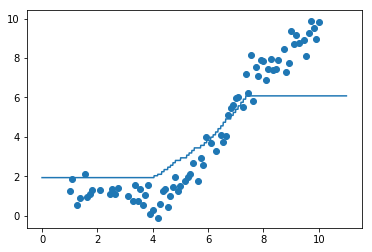

In [6]:
# Assignment 1 
# Optimization
# Early Stopping
# Learning rate decay
# Momentum

import tensorflow as tf
import numpy as np
import sys

# 1.2 Euclidean Distance Function 
# 1.2.2 Pairwise Distances
# Write a vectorized Tensorflow Python function that implements
# the pairwise squared Euclidean distance function for two input matrices.
# No Loops and makes use of Tensorflow broadcasting.
def PairwiseDistances(X, Z):
    """
    input:
        X is a matrix of size (B x N)
        Z is a matrix of size (C x N)
    output:
        D = matrix of size (B x C) containing the pairwise Euclidean distances
    """
    B = X.get_shape().as_list()[0]
    N = X.get_shape().as_list()[1]
    C = Z.get_shape().as_list()[0]
    # Ensure the N dimensions are consistent
    assert  N == Z.get_shape().as_list()[1]
    # Reshape to make use of broadcasting in Python
    X = tf.reshape(X, [B, 1, N])
    Z = tf.reshape(Z, [1, C, N])
    # The code below automatically does broadcasting
    D = tf.reduce_sum(tf.square(tf.subtract(X, Z)), 2)
    return D

# 1.3 Making Predictions
# 1.3.1 Choosing nearest neighbours
# Write a vectorized Tensorflow Python function that takes a pairwise distance matrix
# and returns the responsibilities of the training examples to a new test data point. 
# It should not contain loops.
# Use tf.nn.top_k
def ChooseNearestNeighbours(D, K):
    """
    input:
        D is a matrix of size (B x C)
        K is the top K responsibilities for each test input
    output:
        topK are the value of the squared distances for the topK
        indices are the index of the location of these squared distances
    """
    # Take topK of negative distances since it is the closest data.
    topK, indices = tf.nn.top_k(tf.negative(D), K)
    return topK, indices

# 1.3.2 Prediction
# Compute the k-NN prediction with K = {1, 3, 5, 50}
# For each value of K, compute and report:
    # training MSE loss
    # validation MSE loss
    # test MSE loss
# Choose best k using validation error = 50
def PredictKnn(trainData , testData, trainTarget,  testTarget, K):
    """
    input:
        trainData
        testData
        trainTarget
        testTarget
    output:
        loss
    """
    D = PairwiseDistances(testData, trainData)
    topK, indices = ChooseNearestNeighbours(D, K)
    # Select the proper outputs to be averaged from the target values and average them
    trainTargetSelectedAveraged = tf.reduce_mean(tf.gather(trainTarget, indices), 1)
    # Calculate the loss from the actual values
    # Divide by 2.0 since it's average over 2M instead of M where M = number of training data.
    loss = tf.reduce_mean(tf.square(tf.subtract(trainTargetSelectedAveraged, testTarget)))/2.0
    return loss

# Plot the prediction function for x = [0, 11] on training data.
def PredictedValues(x, trainData, trainTarget, K):
    """
    Plot the predicted values
    input:
        x = test target to plot and predict
    """
    D = PairwiseDistances(x, trainData)
    topK, indices = ChooseNearestNeighbours(D, K)
    predictedValues = tf.reduce_mean(tf.gather(trainTarget, indices), 1)
    return predictedValues



def SortData(inputVal, outputVal):
    """
    This sorts a given test set by the dataValue before plotting it.
    """
    p = np.argsort(inputVal, axis=0)
    inputVal = np.array(inputVal)[p]
    outputVal = np.array(outputVal)[p]
    inputVal = inputVal[:, :,0]
    outputVal = outputVal[:, :,0]
    return inputVal, outputVal

if __name__ == "__main__":
    N = 2 # number of dimensions
    B = 3 # number of test inputs (To get the predictions for all these inputs
    C = 2 # number of training inputs (Pick closest k from this C)
    X = tf.constant([1, 2, 3, 4, 5, 6], shape=[3, 2])
    Z = tf.constant([21, 22, 31, 32], shape=[2, 2])
    # Need to put seed so random_uniform doesn't generate new random values
    # each time you evaluate when you print, so then the values would be 
    # inconsistent as to what you would have used or checked
    #X = tf.random_uniform([B, N], seed=111)*30
    #Z = tf.random_uniform([C, N], seed=112)*30
    D = PairwiseDistances(X, Z)
    K = 1 # number of nearest neighbours
    # You calculate all the pairwise distances between each test input
    # and existing training input
    topK, indices = ChooseNearestNeighbours(D, K)
    # Prediction
    #for K in [1, 3, 5, 50]:
    for K in [50]:
        np.random.seed(521)
        Data = np.linspace(1.0 , 10.0 , num =100) [:, np.newaxis]
        Target = np.sin( Data ) + 0.1 * np.power( Data , 2) + 0.5 * np.random.randn(100 , 1)
        randIdx = np.arange(100)
        np.random.shuffle(randIdx)
        # data1D.npy
        trainData, trainTarget  = Data[randIdx[:5]], Target[randIdx[:5]]
        trainData, trainTarget  = Data[randIdx[:80]], Target[randIdx[:80]]
        validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
        testData, testTarget = Data[randIdx[90:93]], Target[randIdx[90:93]]
        testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

        #trainData, trainTarget = SortData(trainData, trainTarget)
        #validData, validTarget = SortData(validData, validTarget)
        testData, testTarget = SortData(testData, testTarget)


        # Convert to tensors from numpy
        trainData = tf.stack(trainData)
        validData = tf.stack(validData)
        testData = tf.stack(testData)
        trainTarget = tf.stack(trainTarget)
        validtarget = tf.stack(validTarget)
        testTarget = tf.stack(testTarget)
        trainMseLoss = PredictKnn(trainData, trainData, trainTarget, trainTarget, K)
        validationMseLoss = PredictKnn(trainData, validData, trainTarget, validTarget, K)
        testMseLoss = PredictKnn(trainData, testData, trainTarget, testTarget, K)
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
            print('K ' + str(K))
            print('trainMseLoss')
            print(sess.run(trainMseLoss))
            print('validationMseLoss')
            print(sess.run(validationMseLoss))
            print('testMseLoss')
            print(sess.run(testMseLoss))
        
        # Plot the prediction for the x below
        x = np.linspace(0.0, 11.0, num=1000)[:, np.newaxis]
        xTensor = tf.stack(x)
        predictedValuesKnn = PredictedValues(xTensor, trainData, trainTarget, K)
 
        import matplotlib.pyplot as plt
        plt.figure(0)
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            plt.figure(K+100)
            plt.scatter(sess.run(trainData), sess.run(trainTarget))
            plt.plot(sess.run(xTensor), sess.run(predictedValuesKnn))
            fileName = str("KNN") + str(K) + str("trainingGraph.png")
            plt.savefig(fileName)

